# Fun with language modelling

Если вы пропустили лекцию, то посмотрите слайды к ней — они где-то есть. Также полезно почитать:

* [Unreasonable effectiveness of RNN](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) (Andrej Karpathy)
* [Официальный гайд от TensorFlow](https://www.tensorflow.org/tutorials/sequences/recurrent)

Домашка сложная, но интересная. Рекомендуется заранее всё прочитать, чтобы понять, что от вас хотят.

Отсутствие багов и плохих практик в коде не гарантируется — можете переписать всё так, как подсказывает ваше сердце.

---

In [46]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

import re
from sklearn.model_selection import train_test_split

np.random.seed(1759)
tf.set_random_seed(1759)

## Препроцессинг (2 балла)

Возьмите какие-нибудь сырые данные. Википедия, «Гарри Поттер», «Игра Престолов», твиты Тинькова — что угодно.

Для простоты будем делать char-level модель. Выкиньте из текстов все ненужные символы (можете оставить только алфавит и, возможно, пунктуацию). Сопоставьте всем различным символам свой номер. Удобно это хранить просто в питоновском словаре (`char2idx`). Для генерации вам потребуется ещё и обратный словарь (`idx2char`).

Заранее зарезервируйте там место под служебные символы: `<START>`, `<END>`, `<PAD>`, `<UNK>`.

Клёво будет написать отдельный класс, который делает токенизацию и детокенизацию.

In [10]:
def tokenize_string(string):
    string = re.sub(r"[^А-Яа-я0-9(),!?\'\`’:]", " ", string)  
    string = re.sub(r"’", "'", string) 
    string = re.sub(r"`", "'", string) 
    string = re.sub(r"\'s", " \'s", string) 
    string = re.sub(r"\'ve", " \'ve", string) 
    string = re.sub(r"n\'t", " n\'t", string) 
    string = re.sub(r"\'re", " \'re", string) 
    string = re.sub(r"\'d", " \'d", string) 
    string = re.sub(r"\'ll", " \'ll", string) 
    string = re.sub(r",", " , ", string) 
    string = re.sub(r":", " : ", string) 
    string = re.sub(r"!", " ! ", string) 
    string = re.sub(r"\(", " ( ", string) 
    string = re.sub(r"\)", " ) ", string) 
    string = re.sub(r"\?", " ? ", string) 
    string = re.sub(r"\s{2,}", " ", string)    
    return string.strip().lower()

In [16]:
enumerate(set(tokenize_string(file)))

In [17]:
d={1:'re'}

In [18]:
d.update({2:'et',3:'dsg'})

In [30]:
d = Vocab(file)

In [32]:
d.detokenize(d.tokenize(file))

"в земле была нора , а в норе жил хоббит нора была вовсе не грязная и совсем не сырая не копошились в ней черви , не лепились по стенам слизняки , нет в норе было сухо и тепло , пахло приятно , имелось там на что присесть и что покушать , словом , нора принадлежала хоббиту , а стало быть , само собой , была уютной во всех отношениях входная дверь в нору , круглая , точно люк , со сверкающей медной ручкой посредине , была выкрашена в зеленый цвет открывалась она в просторный и длинный коридор , похожий на пещеру , но чистый и ничуть не задымленный в нем стояли стулья , пол устилали ковры , стены , обшитые деревянными панелями , оснащены были великим множеством крючков для плащей и шляп этот хоббит просто обожал принимать гостей коридор , изгибаясь , проходил в глубине холма или кручи , как называли холм на много миль окрест по обеим сторонам коридора в два ряда тянулись маленькие круглые дверцы , за которыми скрывались самые разные помещения , так что лазать наверх или спускаться вниз х

In [29]:
class Vocab:
    def __init__(self, data):
        
        self.char2idx = {'<PAD>':0,'<START>':1,'<END>':2,'<UNK>':3}
        self.char2idx.update({ch:i+4 for i,ch in enumerate(set(tokenize_string(data)))})
        self.idx2char = {i:ch for ch,i in self.char2idx.items()}
    
    def tokenize(self, sequence):
        sequence = tokenize_string(sequence)
        return [self.char2idx[char] for char in sequence]
    
    def detokenize(self, sequence):
        return ''.join([self.idx2char[idx] for idx in sequence])
    
    def __len__(self):
        return len(self.char2idx)

In [43]:
#data_path = # ...

file = ''
with open('tolkien_text.txt',encoding='utf-8') as f:
    file = f.read()

# загрузите данные
data = file

# обучите вокаб
tokenizer = Vocab(data)

t_data = tokenizer.tokenize(data)
# разделите данные на отдельные сэмплы для обучения
# (просто список из сырых строк)
length = 50
data = np.array([t_data[r:r+length] for r in range(0,len(t_data),length)])

In [47]:
len(data)


64410

Если у вас какой-то большой массив текста (скажем, статьи Википедии), вы можете просто нарезать из него кусочки фиксированной длины и так их подавать в модель.

(Опционально) Иногда вы хотите приключений и, скажем, разбить этот текст на предложения (`nltk.sent_tokenize`), и тогда все примеры будут разной длины. По соображениям производительности, вы не хотите использовать самые длинные и самые короткие сэмплы, поэтому имеет смысл обрезать их по длине.

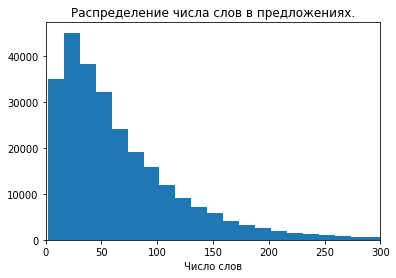

In [8]:
plt.hist([len(x) for x in text], bins=350)
plt.title('Распределение числа слов в предложениях.')
plt.xlabel('Число слов')
plt.xlim((0, 300))
plt.show()

In [9]:
min_len = 40  # предложения с меньшим количеством символов не будут рассматриваться
max_len = 150 # предложения с большим количеством символов будут обрезаться

In [49]:
train,test = train_test_split(data,test_size=0.3)
print(train.shape)
print(test.shape)

(45087,)
(19323,)


## Модель (1 балл) и обучение (3 балла)

Примерно такое должно зайти:

* Эмбеддинг
* LSTM / GRU
* Дропаут
* Линейный слой
* Softmax

Рекомендуется некоторые части не писать самому, а пользоваться готовыми функциями из `tf.contrib.seq2seq`. Будет проще, если обернуть итоговую модель в `Estimator`.

In [16]:
def create_data_dict(data, mode):
    if mode == 'predict':
        return {
            'sequence_beginnings': data[0], 
            'beginning_lengths': tf.reshape(data[1], shape=[-1]), 
            'start_tokens': tf.reshape(data[2], shape=[-1])
        }
    else:
        return {
            'sequences': data[0], 
            'lengths': tf.reshape(data[1], shape=[-1])
        }


def input_fn(data, params, mode):    
    dataset = tf.data.Dataset.from_tensor_slices(data)

    if mode == 'train':
        dataset = dataset.shuffle(buffer_size=params['train_size'], reshuffle_each_iteration=True)
        dataset = dataset.repeat(count=params['num_epochs'])

    dataset = dataset.batch(params['batch_size'])
    dataset = dataset.map(lambda *x: create_data_dict(x, mode))
    dataset = dataset.prefetch(buffer_size=1)
    
    return dataset

In [17]:
def model_fn(features, mode, params):
    
    # матрица эмбеддингов
    embeddings = # ...
    
    # (многослойная) LSTM
    # ...
    
    # Опционально: обучаемое начальное состояние
    # (если не делаете, то убедитесь, что вы всегда инициализируете его нулями перед каждым прогоном)
    # ...
    
    # режимы, в которых необходимо считать loss для готовых последовательностей (train, eval и spellcheck).
    if mode == tf.estimator.ModeKeys.TRAIN or mode == tf.estimator.ModeKeys.EVAL or
        (mode == tf.estimator.ModeKeys.PREDICT and 'start_tokens' not in features):
        
        sequences = features['sequences']
        lengths = features['lengths']
        current_batch_size = tf.shape(sequences)[0]
        
        multiples = tf.stack([current_batch_size, 1])
        initial_states = tuple(tf.nn.rnn_cell.LSTMStateTuple(tf.tile(initial_hidden_states[i], multiples), 
                                                             tf.tile(initial_cell_states[i], multiples)) 
                               for i in range(params['num_layers']))
            
        sequences_embedded = tf.nn.embedding_lookup(params=embeddings, ids=sequences)
            
        supervised_helper = tf.contrib.seq2seq.TrainingHelper(inputs=sequences_embedded, 
                                                              sequence_length=lengths)
        
        supervised_decoder = tf.contrib.seq2seq.BasicDecoder(cell=cell, 
                                                             helper=supervised_helper, 
                                                             initial_state=initial_states)
        
        outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(decoder=supervised_decoder, 
                                                          maximum_iterations=params['max_iter'], 
                                                          impute_finished=True)
        
        logits = outputs.rnn_output
            
        mask = tf.cast(tf.sequence_mask(lengths), dtype=tf.float32)
        
        
        # в режиме spellcheck нужно вернуть loss для каждого элемента последовательностей
        if mode == tf.estimator.ModeKeys.PREDICT:
            losses = tf.contrib.seq2seq.sequence_loss(logits=logits, 
                                                      targets=sequences[:, 1:], 
                                                      weights=mask, 
                                                      average_across_timesteps=False, 
                                                      average_across_batch=False)
            predictions = {
                'sequences': sequences[:, 1:],
                'lengths': lengths,
                'losses': losses
            }
            
            return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
        else:
            loss = tf.contrib.seq2seq.sequence_loss(logits=logits, 
                                                    targets=sequences[:, 1:], 
                                                    weights=mask, 
                                                    average_across_timesteps=True, 
                                                    average_across_batch=True)
            # в режиме eval возвращаем усреднённый лосс
            if mode == tf.estimator.ModeKeys.EVAL:
                return tf.estimator.EstimatorSpec(mode, loss=loss)
            
            # в режиме train ещё и обновляем обучаемые параметры
            elif mode == tf.estimator.ModeKeys.TRAIN:
                optimizer = tf.train.AdamOptimizer
                optimizer = optimizer(learning_rate=params['learning_rate'])
                train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
                
                return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)
    
    # в режиме predict генерируем продолжения заданных последовательностей.
    elif mode == tf.estimator.ModeKeys.PREDICT and 'start_tokens' in features:
        sequence_beginnings = features['sequence_beginnings']
        beginning_lengths = features['beginning_lengths']
        start_tokens = features['start_tokens']
        current_batch_size = tf.shape(start_tokens)[0]

        multiples = tf.stack([current_batch_size, 1])
        initial_states = tuple(tf.nn.rnn_cell.LSTMStateTuple(tf.tile(initial_hidden_states[i], multiples), 
                                                             tf.tile(initial_cell_states[i], multiples))
                               for i in range(params['num_layers']))

        sequence_beginnings_embedded = tf.nn.embedding_lookup(params=embeddings, ids=sequence_beginnings)        
        
        # пропустим заданные последовательности через сеть,
        # чтобы получить скрытые состояния LSTM перед началом генерации
        encoding_helper = tf.contrib.seq2seq.TrainingHelper(inputs=sequence_beginnings_embedded, 
                                                            sequence_length=beginning_lengths)

        encoder = tf.contrib.seq2seq.BasicDecoder(cell=cell, 
                                                  helper=encoding_helper, 
                                                  initial_state=initial_states)

        _, encoder_final_states, _ = tf.contrib.seq2seq.dynamic_decode(decoder=encoder, 
                                                                       maximum_iterations=params['max_iter'], 
                                                                       impute_finished=True)

        decoder_initial_states = tf.contrib.seq2seq.tile_batch(encoder_final_states, multiplier=params['beam_width'])

        # будем использовать beam search для выбора наилучшего продолжения
        beam_search_decoder = tf.contrib.seq2seq.BeamSearchDecoder(cell=cell, 
                                                                 embedding=embeddings, 
                                                                 start_tokens=start_tokens, 
                                                                 end_token=end_symbol_id, 
                                                                 initial_state=decoder_initial_states, 
                                                                 beam_width=params['beam_width'])

        outputs, _, ending_lengths = tf.contrib.seq2seq.dynamic_decode(decoder=beam_search_decoder, 
                                                                       maximum_iterations=params['max_iter'], 
                                                                       impute_finished=False)

        predicted_ids = tf.squeeze(outputs.predicted_ids[:, :, 0])
        sequence_endings = tf.concat([tf.reshape(start_tokens, shape=(-1, 1)), predicted_ids], axis=1)
        ending_lengths = tf.squeeze(ending_lengths[:, 0]) + 1

        predictions = {
            'sequence_beginnings': sequence_beginnings[:, 1:], 
            'beginning_lengths': beginning_lengths - 1, 
            'sequence_endings': sequence_endings, 
            'ending_lengths': ending_lengths
        }
        
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

In [18]:
params = {
    'vocab_size': len(Vocab),
    'train_size': len(training_data[0]),
    'num_layers': 2,
    'embedding_dim': 300,
    'lstm_hidden_dim': 300,
    'dropout_keep_prob': 0.7,
    'max_iter': max_len,
    'initial_state_is_zero': True,
    'beam_width': 10,
    'batch_size': 256,
    'num_epochs': 10,
    'learning_rate': 1e-3
}

config = tf.estimator.RunConfig(model_dir='language_model')
model = tf.estimator.Estimator(model_fn=model_fn, params=params, config=config)

In [ ]:
params['num_epochs'] = 5
params['learning_rate'] = 1e-3
model.train(lambda: input_fn(training_data, params=params, mode='train'))

In [ ]:
model.evaluate(lambda: input_fn(validation_data, params=params, mode='eval'))

## Спеллчекер (1 балла)

Из языковой модели можно сделать простенький спеллчекер: можно визуализировать лоссы на каждом символе.

Бонус: можете усреднить перплексии по словам и выделять их, а не отдельные символы.

In [26]:
from IPython.core.display import display, HTML

def print_colored(sequence, intensities, delimeter=''):
    html = delimeter.join([
        f'<span style="background: rgb({255}, {255-x}, {255-x})">{c}</span>'
        for c, x in zip(sequence, intensities) 
    ])
    display(HTML(html))

print_colored('Налейте мне экспрессо'.split(), [0, 0, 100], ' ')

sequence = 'Эту домашку нужно сдать втечении двух недель'
intensities = [0]*len(sequence)
intensities[25] = 50
intensities[26] = 60
intensities[27] = 70
intensities[31] = 150
print_colored(sequence, intensities)

In [27]:
def spellcheck(sequences):
    # токенизируйте и западьте каждый sequence
    # sequence = ...
    
    output = model.predict(lambda: input_fn(sequences_to_spellcheck, params=params, mode='spellcheck'))
    
    # детокенизируйте выход, выкиньте паддинги
    sequences = # ...
    
    # с losses можно что-нибудь сделать для визуализации; например, в какую-нибудь степень возвести
    losses = # ...
    
    for i in range(len(sequences_spellchecked)):
        print_colored(sequences_spellchecked[i], np.array(spellcheck_losses[i]))

In [28]:
sequences = ['В этом претложениии очен много очепяток.', 
             'Здесь появилась лишнняя буква.', 
             'В этом предложении все нормально.', 
             'Чтонибудь пишеться чериз дефис.', 
             'Слова нрпдзх не сущесдвует.']

spellcheck(sequences)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model_dir\language_model_10\model.ckpt-5996
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.



## Генерация предложений (3 балла)

* Поддерживайте hidden state при генерации. Не пересчитывайте ничего больше одного раза.
* Прикрутите температуру: это когда при сэмплировании все логиты (то, что перед софтмаксом) делятся на какое-то число (по умолчанию 1, тогда ничего не меняется). Температура позволяет делать trade-off между разнообразием и правдоподобием (подробнее — см. блог Карпатого).
* Ваша реализация должна уметь принимать строку seed — то, с чего должно начинаться сгенерированная строка.

Если сделаете все вышеперечисленное, то получите 2 балла. Если сделаете хоть какую-то генерацию, то 1 балл.

In [29]:
def sample(sequences, temperature=1.0):
    # препроцессинг над sequences
    sequences = ...

    predictions = model.predict(lambda: input_fn(sequences, params=params, mode='predict'))
    sequences = # детокенизируйте обратно

    for seq in sequences:
        print(seq)

In [ ]:
beginnings = ['Шел медведь по лесу', 
              'Встретились англичанин, американец и русский. Англичанин говорит:',
              'Так вот, однажды качки решили делать ремонт',
              'Поручик Ржевский был',
              'Идёт Будда с учениками по дороге',
              'Мюллер: Штирлиц, где вы были в 1938 году?',
              'Засылают к нам американцы шпиона под видом студента',
              'Подъезжает электричка к Долгопе:'
              ]

sample(beginnings)